<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 1) Autoencoder for Persian Numbers</b><br>
Train an autoencoder on Persian numbers to remove noise from the numbers.
</div>

In [1]:
import matplotlib.pyplot as plt

# cv2 and io for loading hoda
import cv2
from scipy import io

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
# from load_hoda import load_hoda

In [30]:
def load_hoda(training_sample_size=1000, test_sample_size=200, size=5):
    #load dataset
    trs = training_sample_size
    tes = test_sample_size
    dataset = io.loadmat('Data_hoda_full.mat')

    #test and training set
    X_train_orginal = np.squeeze(dataset['Data'][:trs])
    y_train = np.squeeze(dataset['labels'][:trs])
    X_test_original = np.squeeze(dataset['Data'][trs:trs+tes])
    y_test = np.squeeze(dataset['labels'][trs:trs+tes])

    #resize
    X_train_5by5 = [cv2.resize(img, dsize=(size, size)) for img in X_train_orginal]
    X_test_5by_5 = [cv2.resize(img, dsize=(size, size)) for img in X_test_original]
    #reshape
    X_train = np.reshape(X_train_5by5, [-1,size**2])
    X_test = np.reshape(X_test_5by_5, [-1,size**2])

    return X_train, y_train, X_test, y_test

In [31]:
# (x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train, y_train, x_test, y_test = load_hoda(size = 20)

In [32]:
x_train.shape

(1000, 400)

In [33]:
x_train= x_train.reshape(-1, 20, 20, 1)
x_test= x_test.reshape(-1, 20, 20, 1)

In [34]:
print(x_train.shape)
print(x_test.shape)

(1000, 20, 20, 1)
(200, 20, 20, 1)


In [35]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)

(1000, 20, 20, 1)


Adding random noise to the images

In [36]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


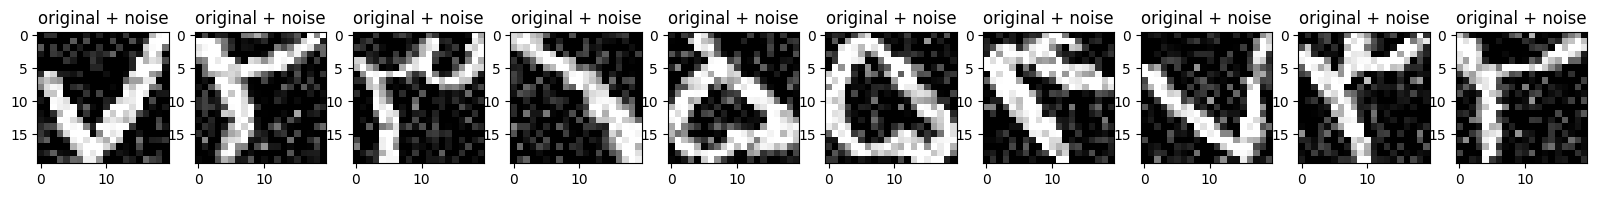

In [37]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder
### Using upsampling instead of Conv2DTranspose



In [40]:
class Denoise_v2(Model):
  def __init__(self):
    super(Denoise_v2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(x_train.shape[1], x_train.shape[2], 1)), # 20 x 20 x 1
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), # 10 x 10 x 16
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)]) # 5 x 5 x 8

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)), # 10 x 10 x 8
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'), # 10 x 10 x 8
      layers.UpSampling2D(size=(2, 2)), # 20 x 20 x 8
      layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'), #20 x 20 x 16
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')]) # 20 x 20 x 1

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise_v2()
autoencoder.summary()

Model: "denoise_v2_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 5, 5, 8)             │           1,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [42]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.2049 - val_loss: 0.0993
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0764 - val_loss: 0.0522
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 - val_loss: 0.0387
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - val_loss: 0.0316
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.0290
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.0266
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.0246
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0231
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 0.0209


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [43]:
autoencoder.encoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 5, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [44]:
autoencoder.decoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ up_sampling2d_4 (UpSampling2D)       │ (None, 10, 10, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 10, 10, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 20, 20, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 20, 20, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 20, 20, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [45]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

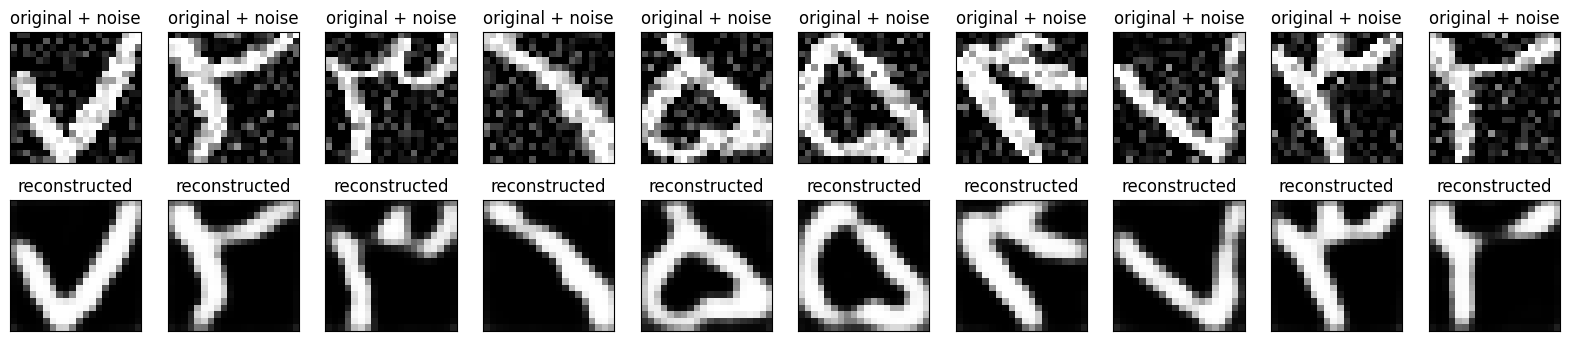

In [46]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()